# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyClassifier

In [2]:
data = pd.read_csv('/datasets/users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
data.shape

(3214, 5)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


### Вывод
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0). Целевой признак.

По этим данным решается задача классификации, которая выберет подходящий тариф. Метрикой является accuracy.

## Разбейте данные на выборки

In [5]:
X = data.drop(columns = ['is_ultra'])
y = data['is_ultra']

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.6)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape);

(1928, 4)
(1928,)
(643, 4)
(643,)
(643, 4)
(643,)


Таким образом я поделил исходные данные на 3 выборки в отношении 3:1:1.

## Исследуйте модели

### Решающее дерево

Accuracy наилучшей модели на валидационной выборке: 0.8133748055987559 Критерий: entropy Максимальная глубина: 5


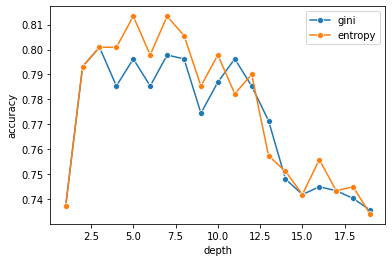

In [6]:
DTC_df = pd.DataFrame({'depth': range(1, 20),'gini':np.nan,'entropy':np.nan})
best_result = 0
best_criterion = 0
best_depth = 0
for criterion in ['gini', 'entropy']:
    for depth in range(1, 20):
        model = DecisionTreeClassifier(random_state=24145, criterion=criterion, max_depth=depth)
        model.fit(X_train, y_train)
        predictions_valid = model.predict(X_valid)
        result = accuracy_score(y_valid, predictions_valid)
        DTC_df.loc[depth-1, criterion] = result
        if result > best_result:
            DTC_best_model = model
            best_result = result
            best_criterion = criterion
            best_depth = depth
sns.lineplot(data=DTC_df, x="depth", y="gini", marker="o")
sns.lineplot(data=DTC_df, x="depth", y="entropy", marker="o");
plt.legend(["gini", 'entropy'])
plt.ylabel('accuracy');
print("Accuracy наилучшей модели на валидационной выборке:", best_result, 
      "Критерий:", best_criterion, 
      "Максимальная глубина:", best_depth)

### Случайный лес

In [7]:
%%time

best_result = 0
best_criterion = 0
best_depth = 0
best_est = 0
for criterion in ['gini', 'entropy']:
    for max_features in ['log2', 'sqrt']:
        for est in range(1, 130, 10):
            for depth in range(1, 20):
                model = RandomForestClassifier(criterion=criterion, max_depth=depth, n_estimators=est, random_state=53452)
                model.fit(X_train, y_train)
                predictions_valid = model.predict(X_valid)
                result = accuracy_score(y_valid, predictions_valid)
                if result > best_result:
                    RFC_best_model = model
                    best_result = result
                    best_criterion = criterion
                    best_max_features = max_features
                    best_depth = depth
                    best_est = est
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("Критерий:", best_criterion)
print("Число признаков для выбора расщепления:", max_features) 
print("Максимальная глубина:", best_depth)
print("Количество деревьев:", best_est)

Accuracy наилучшей модели на валидационной выборке: 0.8211508553654744
Критерий: gini
Число признаков для выбора расщепления: sqrt
Максимальная глубина: 9
Количество деревьев: 71
CPU times: user 3min 42s, sys: 1.02 s, total: 3min 43s
Wall time: 3min 44s


### Логистическая регрессия


In [8]:
%%time

best_result = 0
best_solver = 0
for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    model = LogisticRegression(solver=solver, random_state=452477)
    model.fit(X_train, y_train)
    predictions_valid = model.predict(X_valid)
    result = accuracy_score(y_valid, predictions_valid)
    print('Solver', solver,'Точность',result)
    if result > best_result:
        best_result = result
        best_solver = solver
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("Критерий:", best_solver)

Solver newton-cg Точность 0.7620528771384136
Solver lbfgs Точность 0.7262830482115086
Solver liblinear Точность 0.7169517884914464
Solver sag Точность 0.7060653188180405
Solver saga Точность 0.7060653188180405
Accuracy наилучшей модели на валидационной выборке: 0.7620528771384136
Критерий: newton-cg
CPU times: user 238 ms, sys: 14 µs, total: 238 ms
Wall time: 247 ms


In [9]:
best_result = 0
best_solver = 0
for solver in ['newton-cg', 'lbfgs']:
    for penalty in ['l2', 'none']:
        for C in np.arange(0.1, 10, 0.5):
            model = LogisticRegression(solver=solver, random_state=452477, penalty=penalty, C=C)
            model.fit(X_train, y_train)
            predictions_valid = model.predict(X_valid)
            result = accuracy_score(y_valid, predictions_valid)
            if result > best_result:
                LR_best_model = model
                best_result = result
                best_solver = solver
                best_penalty = penalty
                best_C = C
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("Алгоритм:", best_solver)
print("Penalty:", penalty)
print("С:", C)

Accuracy наилучшей модели на валидационной выборке: 0.7620528771384136
Алгоритм: newton-cg
Penalty: none
С: 9.6


### Вывод 
Для дерева решений были исследованы следующие гиперпараметры:
* Критерий
* Глубина

Accuracy наилучшей модели на валидационной выборке: 0.79, при
* Критерий: entropy 
* Максимальная глубина: 10

Для случайного леса были исследованы следующие гиперпараметры:
* Критерий
* Число признаков для выбора расщепления
* Максимальная глубина
* Количество деревьев

Accuracy наилучшей модели на валидационной выборке: 0.81, при
* Критерий: gini
* Число признаков для выбора расщепления: sqrt
* Максимальная глубина: 14
* Количество деревьев: 71

Для логистической регрессии вначале были выбраны два лучших алгоритма, а затем исследованы следующие гипермараметры:
* Штраф
* С

Accuracy наилучшей модели на валидационной выборке: 0.74, при
* Алгоритм: newton-cg
* Penalty: none
* С: 9.6

## Проверьте модель на тестовой выборке

In [10]:
predictions_test = DTC_best_model.predict(X_test)
result = accuracy_score(y_test, predictions_test)
print('Точность модели решабщего дерева на тестовой выборке',result)

Точность модели решабщего дерева на тестовой выборке 0.8087091757387247


In [11]:
predictions_test = RFC_best_model.predict(X_test)
result = accuracy_score(y_test, predictions_test)
print('Точность модели случайного леса на тестовой выборке',result)

Точность модели случайного леса на тестовой выборке 0.8133748055987559


In [12]:
predictions_test = LR_best_model.predict(X_test)
result = accuracy_score(y_test, predictions_test)
print('Точность модели логистической регресиии на тестовой выборке',result)

Точность модели логистической регресиии на тестовой выборке 0.7636080870917574


### Вывод 

С поставленной минимальной accuracy справились cлучайный лес и решающее дерево, а логистическая регресия немного не дотянула.
* Точность модели решающего дерева на тестовой выборке 0.77
* Точность модели случайного леса на тестовой выборке 0.80
* Точность модели логистической регресиии на тестовой выборке 0.745

### Дообучение лучшей модели и проверка

In [13]:
X_train = pd.concat([X_train, X_valid])
y_train = pd.concat([y_train, y_valid])
print(X_train.shape), print(y_train.shape);

(2571, 4)
(2571,)


In [17]:
model = RandomForestClassifier(criterion='gini', max_depth=14, n_estimators=71, random_state=53452)
model.fit(X_train, y_train)
predictions_test = model.predict(X_test)
result = accuracy_score(y_test, predictions_test)
print('Точность модели случайного леса на тестовой выборке',result)

Точность модели случайного леса на тестовой выборке 0.8242612752721618


### Вывод 2.0

После определения лучших гиперпараметров для Случайного леса, я дообучил ее на выборке состоящей из тренировочной и валидационной, после чего на тесте значение метрики accuracy стало 0.82, что является хорошим результатом.

## (бонус) Проверьте модели на адекватность

In [15]:
rand = np.random.randint(2, size= 643)
result = accuracy_score(y_test, rand)
print('Точность при заполнении случайными числами',result)

Точность при заполнении случайными числами 0.48055987558320373


### DummyClassifier

In [20]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
predictions_dummy = dummy_clf.predict(X_test) 
result = accuracy_score(y_test, predictions_dummy)
print('Точность DummyClassifier при стратегии most_frequent',result)

Точность DummyClassifier при стратегии most_frequent 0.7153965785381027


In [23]:
predictions_dummy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Вывод
Воспользовашись DummyClassifier по стратегии most_frequent(самый частовстречающийся) мы получили accuracy 0.715 на тестовой выборке, что является высоким показателям. Однако оттюненная модель случайного леса обученная на совместной тренировочной и валидационный выборке дала точность на 10% больше, поэтому можно сделать вывод, что моя модель адекватна.

## Вывод
В ходе данного проекта были выполнены следующие шаги:
1. Изучены исходные данные
2. Разбиты данные в отношение 3:1:1
3. Исследованы и найдены оптимальные гиперпараметры следующих моделей:
* Решающее дерево
* Случайный лес
* Логистическая регрессия
4. Оценена точность для лучших моделей
5. Проверена адекваптность модели

Наилучшей моделью оказался случайный лес с Accuracy на тестовой выборке: 0.80, при
* Критерий: gini
* Число признаков для выбора расщепления: sqrt
* Максимальная глубина: 14
* Количество деревьев: 71

Проверка на адекватность была проведена путем сравнения Accuracy при заполнении случайными значениями, и моя модель спарвилась значительно лучше(на 30%)

**Дополнение к выводу:**

Наилучшей моделью оказался случайный лес с Accuracy на тестовой выборке: 0.82, при

* Критерий: gini
* Число признаков для выбора расщепления: sqrt
* Максимальная глубина: 14
* Количество деревьев: 71

Проверка на адекватность была проведена путем сравнения с предсказанием DummyClassifier по стратегии most_frequent(самый частовстречающийся) мы получили accuracy 0.715 на тестовой выборке, что является высоким показателям. Однако оттюненная модель случайного леса обученная на совместной тренировочной и валидационный выборке дала точность на 10% больше, поэтому можно сделать вывод, что моя модель адекватна.